In [1]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)
#tf.config.list_physical_devices(device_type=None)

import tensorflow.keras
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D

from keras import callbacks 
from keras.constraints import maxnorm
import keras
from sklearn.model_selection import KFold

In [2]:
import os
path, dirs, files = next(os.walk("D:\\Code\\Jupyter\\climate_project\\New Data\\profiles"))
file_count = len(files)
print('The number of profiles:',file_count)

The number of profiles: 4000


In [3]:
#retrieve data
num = 4000 # number of profiles
nvza = 12 # number of channels
nsza=6

# get spatial dimension
fname = "D:\\Code\\Jupyter\\climate_project\\New Data\\profiles/profile_%05d.hdf5" %(1)
hf = h5py.File(fname, 'r')
spatial = hf.get('x') # HDF5 dataset "x": shape (4096,), type "<f8">
x = np.array(spatial) #change it to np array
x_size = np.size(np.array(spatial)) #4096; Dimension: (4096,)
hf.close()

In [4]:
# spatial slicing dimensions
os = 82 # output slice size
ts = os # input slice size 32


In [5]:
#get the averaged reflectance from the dataset 
fname_r = "data_reflectance.h5"
hf_r = h5py.File(fname_r, 'r')
r=hf_r['dataset_reflectance']
r.shape


(4000, 82)

In [6]:
#get the averaged reflectance from the dataset 
fname_c = "data_cot.h5"
hf_c = h5py.File(fname_c, 'r')
c=hf_c['dataset_cot']
c.shape

(4000, 82)

In [7]:
c=c[:]
r=r[:]

In [8]:
r,c= shuffle(r, c, random_state=0)#Shuffle arrays in a consistent way.

#train test split
trp = 0.8; # 80 percent to train, includes validation
train_size=int(trp*num)
test_size = num - train_size #20% for testing:0.20*4000=800

print("train_size:",train_size,'profiles')
print("test_size:",test_size,'profiles')


train_size: 3200 profiles
test_size: 800 profiles


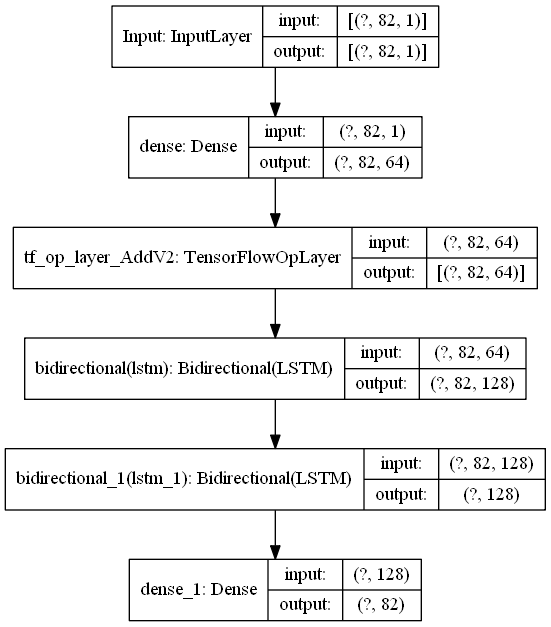

In [10]:
keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,expand_nested=True,rankdir='TB')

In [9]:
#Bi-LSTM model-------------------------------------------------------------------------------------------------



ltype = 'mean_squared_error'
type2=tf.keras.metrics.RootMeanSquaredError()
bsize = 16
eps = 2000



def eval_model(train_image, test_image, train_label, test_label):
    input_layer = tf.keras.layers.Input(shape=(ts,1),name='Input')
    #patch embedding layer
    #The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim
    projection=tf.keras.layers.Dense(64,activation='relu')(input_layer)
    positions = tf.range(start=0, limit=82, delta=1)
    embedding=tf.keras.layers.Embedding(input_dim=(82),output_dim=(64),input_length=128)(positions)
        # adds a learnable position embedding to the projected vector
    encoded = projection+embedding

    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True,input_shape=(ts,1))(encoded) 
    lstm=tf.keras.layers.LSTM(units=64, activation='tanh',return_sequences = True)(lstm) 
    lstm=tf.keras.layers.LSTM(units=96, activation='tanh',return_sequences = True)(lstm) 
    flat=tf.keras.layers.Flatten()(lstm)

    output=tf.keras.layers.Dense(os, activation="linear")(flat)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output)

    model.compile(optimizer='adam',loss='mse',metrics=[ltype,type2])
    
    model.summary()

    #earlystopping to find the optimal number of epochs 
    earlystopping = callbacks.EarlyStopping(monitor ="val_loss",  
                                                mode ="min", patience = 25,  
                                                restore_best_weights = True,
                                               verbose=1) 

    history = model.fit(train_image,train_label,batch_size = bsize,epochs = eps,validation_split=0.125,
                              callbacks =[earlystopping])#validation set(15%)/trainset(85%)=0.17647

    # test and predict ---------------------------------------------------------------------------------------

    print('test result')
    results = model.evaluate(test_image, test_label)
    predictions=model.predict(test_image)

    mse = results[1]
    rmse = results[2]

    return model,rmse,mse,history,predictions

In [10]:
n_folds=5

kf = KFold(n_splits=n_folds,random_state=None, shuffle=False)
print(kf.get_n_splits(r))
print(kf)
ratio=int(r.shape[0]/n_folds)

X_train=np.zeros((5,800*4,ts))
y_train=np.zeros((5,ratio*(n_folds-1),os))
X_test=np.zeros((n_folds,ratio,ts))
y_test=np.zeros((n_folds,ratio,os))

count=0
for train_index, test_index in kf.split(r):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train[count], X_test[count] = r[train_index], r[test_index]
    y_train[count], y_test[count] = c[train_index], c[test_index]
    count+=1

5
KFold(n_splits=5, random_state=None, shuffle=False)
TRAIN: [ 800  801  802 ... 3997 3998 3999] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 

In [11]:
# evaluate model----------------------------------------------------------------------------------------------
cv_scores = list()
cv_scores2 = list()

for n in range(n_folds):
        # split data    
    train_image, test_image, train_label, test_label = X_train[n],X_test[n],y_train[n],y_test[n]
        # evaluate model
    model,rmse,mse,history,predictions= eval_model(train_image, test_image, train_label, test_label)
    print('MSE on test set in fold'+str(n+1)+' : '+str(mse))
    print('RMSE on test set in fold'+str(n+1)+' : '+str(rmse))

    cv_scores.append(mse)
    cv_scores2.append(rmse)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 1)]           0         
_________________________________________________________________
dense (Dense)                (None, 82, 64)            128       
_________________________________________________________________
tf_op_layer_AddV2 (TensorFlo [(None, 82, 64)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 82, 64)            33024     
_________________________________________________________________
lstm_1 (LSTM)                (None, 82, 64)            33024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 82, 96)            61824     
_________________________________________________________________
flatten (Flatten)            (None, 7872)             

175/175 [==============================] - 9s 53ms/step - loss: 0.2471 - mean_squared_error: 0.2471 - root_mean_squared_error: 0.4971 - val_loss: 0.5901 - val_mean_squared_error: 0.5901 - val_root_mean_squared_error: 0.7682
Epoch 64/2000
175/175 [==============================] - 9s 53ms/step - loss: 0.2374 - mean_squared_error: 0.2374 - root_mean_squared_error: 0.4873 - val_loss: 0.5742 - val_mean_squared_error: 0.5742 - val_root_mean_squared_error: 0.7577
Epoch 65/2000
175/175 [==============================] - 10s 55ms/step - loss: 0.2320 - mean_squared_error: 0.2320 - root_mean_squared_error: 0.4816 - val_loss: 0.5747 - val_mean_squared_error: 0.5747 - val_root_mean_squared_error: 0.7581
Epoch 66/2000
175/175 [==============================] - 10s 55ms/step - loss: 0.2248 - mean_squared_error: 0.2248 - root_mean_squared_error: 0.4741 - val_loss: 0.5795 - val_mean_squared_error: 0.5795 - val_root_mean_squared_error: 0.7613
Epoch 67/2000
175/175 [==============================] - 9s 

175/175 [==============================] - 10s 55ms/step - loss: 0.4226 - mean_squared_error: 0.4226 - root_mean_squared_error: 0.6501 - val_loss: 0.6245 - val_mean_squared_error: 0.6245 - val_root_mean_squared_error: 0.7903
Epoch 42/2000
175/175 [==============================] - 9s 52ms/step - loss: 0.4080 - mean_squared_error: 0.4080 - root_mean_squared_error: 0.6388 - val_loss: 0.5757 - val_mean_squared_error: 0.5757 - val_root_mean_squared_error: 0.7588
Epoch 43/2000
175/175 [==============================] - 9s 50ms/step - loss: 0.4145 - mean_squared_error: 0.4145 - root_mean_squared_error: 0.6438 - val_loss: 0.5841 - val_mean_squared_error: 0.5841 - val_root_mean_squared_error: 0.7643
Epoch 44/2000
175/175 [==============================] - 9s 51ms/step - loss: 0.3988 - mean_squared_error: 0.3988 - root_mean_squared_error: 0.6315 - val_loss: 0.6001 - val_mean_squared_error: 0.6001 - val_root_mean_squared_error: 0.7746
Epoch 45/2000
175/175 [==============================] - 9s 5

Epoch 00108: early stopping
test result
25/25 [==============================] - 1s 27ms/step - loss: 0.5281 - mean_squared_error: 0.5281 - root_mean_squared_error: 0.7267
MSE on test set in fold2 : 0.5281441807746887
RMSE on test set in fold2 : 0.7267352342605591
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 82, 1)]           0         
_________________________________________________________________
dense_4 (Dense)              (None, 82, 64)            128       
_________________________________________________________________
tf_op_layer_AddV2_2 (TensorF [(None, 82, 64)]          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 82, 64)            33024     
_________________________________________________________________
lstm_7 (LSTM)                (None, 82, 64)          

175/175 [==============================] - 10s 57ms/step - loss: 0.2842 - mean_squared_error: 0.2842 - root_mean_squared_error: 0.5331 - val_loss: 0.5595 - val_mean_squared_error: 0.5595 - val_root_mean_squared_error: 0.7480
Epoch 63/2000
175/175 [==============================] - 10s 57ms/step - loss: 0.2785 - mean_squared_error: 0.2785 - root_mean_squared_error: 0.5277 - val_loss: 0.5042 - val_mean_squared_error: 0.5042 - val_root_mean_squared_error: 0.7101
Epoch 64/2000
175/175 [==============================] - 10s 57ms/step - loss: 0.2695 - mean_squared_error: 0.2695 - root_mean_squared_error: 0.5191 - val_loss: 0.5071 - val_mean_squared_error: 0.5071 - val_root_mean_squared_error: 0.7121
Epoch 65/2000
175/175 [==============================] - 10s 57ms/step - loss: 0.2601 - mean_squared_error: 0.2601 - root_mean_squared_error: 0.5100 - val_loss: 0.5261 - val_mean_squared_error: 0.5261 - val_root_mean_squared_error: 0.7253
Epoch 66/2000
175/175 [==============================] - 1

175/175 [==============================] - 12s 67ms/step - loss: 2.4083 - mean_squared_error: 2.4083 - root_mean_squared_error: 1.5519 - val_loss: 2.5494 - val_mean_squared_error: 2.5494 - val_root_mean_squared_error: 1.5967
Epoch 18/2000
175/175 [==============================] - 11s 66ms/step - loss: 2.0474 - mean_squared_error: 2.0474 - root_mean_squared_error: 1.4309 - val_loss: 2.1305 - val_mean_squared_error: 2.1305 - val_root_mean_squared_error: 1.4596
Epoch 19/2000
175/175 [==============================] - 11s 63ms/step - loss: 1.6373 - mean_squared_error: 1.6373 - root_mean_squared_error: 1.2796 - val_loss: 1.7252 - val_mean_squared_error: 1.7252 - val_root_mean_squared_error: 1.3135
Epoch 20/2000
175/175 [==============================] - 11s 62ms/step - loss: 1.3354 - mean_squared_error: 1.3354 - root_mean_squared_error: 1.1556 - val_loss: 1.4005 - val_mean_squared_error: 1.4005 - val_root_mean_squared_error: 1.1834
Epoch 21/2000
175/175 [==============================] - 1

175/175 [==============================] - 11s 64ms/step - loss: 0.1470 - mean_squared_error: 0.1470 - root_mean_squared_error: 0.3834 - val_loss: 0.5486 - val_mean_squared_error: 0.5486 - val_root_mean_squared_error: 0.7407
Epoch 86/2000
175/175 [==============================] - 11s 64ms/step - loss: 0.1537 - mean_squared_error: 0.1537 - root_mean_squared_error: 0.3921 - val_loss: 0.5398 - val_mean_squared_error: 0.5398 - val_root_mean_squared_error: 0.7347
Epoch 87/2000
175/175 [==============================] - 11s 62ms/step - loss: 0.1447 - mean_squared_error: 0.1447 - root_mean_squared_error: 0.3804 - val_loss: 0.5398 - val_mean_squared_error: 0.5398 - val_root_mean_squared_error: 0.7347
Epoch 88/2000
175/175 [==============================] - 11s 62ms/step - loss: 0.1415 - mean_squared_error: 0.1415 - root_mean_squared_error: 0.3762 - val_loss: 0.5376 - val_mean_squared_error: 0.5376 - val_root_mean_squared_error: 0.7332
Epoch 89/2000
175/175 [==============================] - 1

175/175 [==============================] - 13s 74ms/step - loss: 0.3281 - mean_squared_error: 0.3281 - root_mean_squared_error: 0.5728 - val_loss: 0.5279 - val_mean_squared_error: 0.5279 - val_root_mean_squared_error: 0.7265
Epoch 55/2000
175/175 [==============================] - 11s 65ms/step - loss: 0.3192 - mean_squared_error: 0.3192 - root_mean_squared_error: 0.5650 - val_loss: 0.5377 - val_mean_squared_error: 0.5377 - val_root_mean_squared_error: 0.7333
Epoch 56/2000
175/175 [==============================] - 11s 64ms/step - loss: 0.3184 - mean_squared_error: 0.3184 - root_mean_squared_error: 0.5643 - val_loss: 0.5151 - val_mean_squared_error: 0.5151 - val_root_mean_squared_error: 0.7177
Epoch 57/2000
175/175 [==============================] - 12s 71ms/step - loss: 0.3065 - mean_squared_error: 0.3065 - root_mean_squared_error: 0.5536 - val_loss: 0.5068 - val_mean_squared_error: 0.5068 - val_root_mean_squared_error: 0.7119
Epoch 58/2000
175/175 [==============================] - 1

In [12]:
#quantitative result: average MSE on test set and its standard deviation
print('Estimated MSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores),np.std(cv_scores)))
print('Estimated RMSE %.4f with standard deviation (%.4f)' % (np.mean(cv_scores2),np.std(cv_scores2)))

Estimated MSE 0.5179 with standard deviation (0.0397)
Estimated RMSE 0.7192 with standard deviation (0.0274)


In [13]:
cv_scores

[0.5853272080421448,
 0.5281441807746887,
 0.49477341771125793,
 0.5154147744178772,
 0.4660705327987671]

In [14]:
cv_scores2

[0.7650668621063232,
 0.7267352342605591,
 0.7034013867378235,
 0.7179238796234131,
 0.682693600654602]

The optimal number of epochs is 74


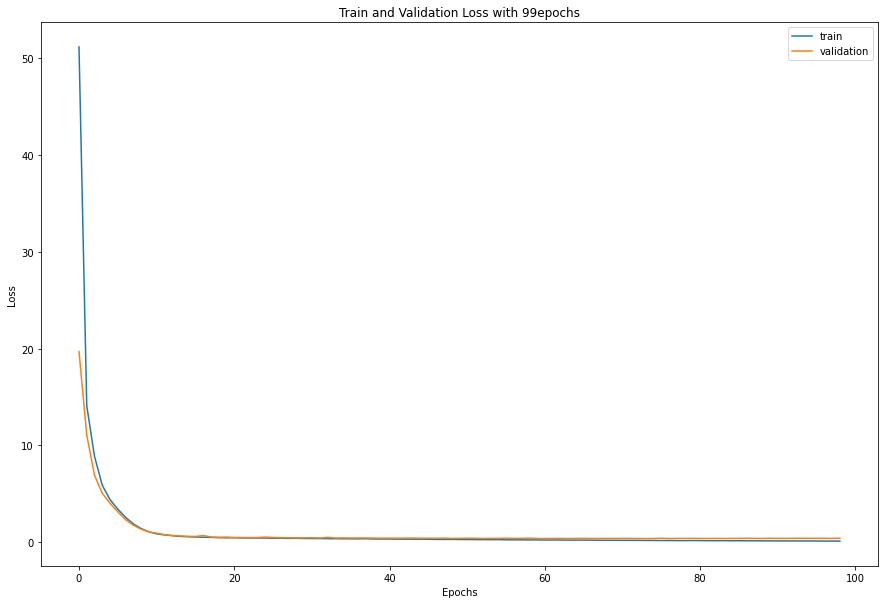

In [18]:
patience=25
plt.figure(figsize=(15,10))

# plot training and validation history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss') 
plt.title('Train and Validation Loss with '+str(len(history.history['val_loss']))+'epochs')
plt.legend()
 
plt.savefig('train_validation_after_'+str(len(history.history['val_loss'])-patience)+"_epochs.png")

print('The optimal number of epochs is '+str(len(history.history['val_loss'])-patience))

In [15]:
predict1=np.zeros(os) 
predict1=predictions[-3]
    
predict2=np.zeros((os))
predict2=predictions[-2]
    
predict3=np.zeros((os))
predict3=predictions[-1]

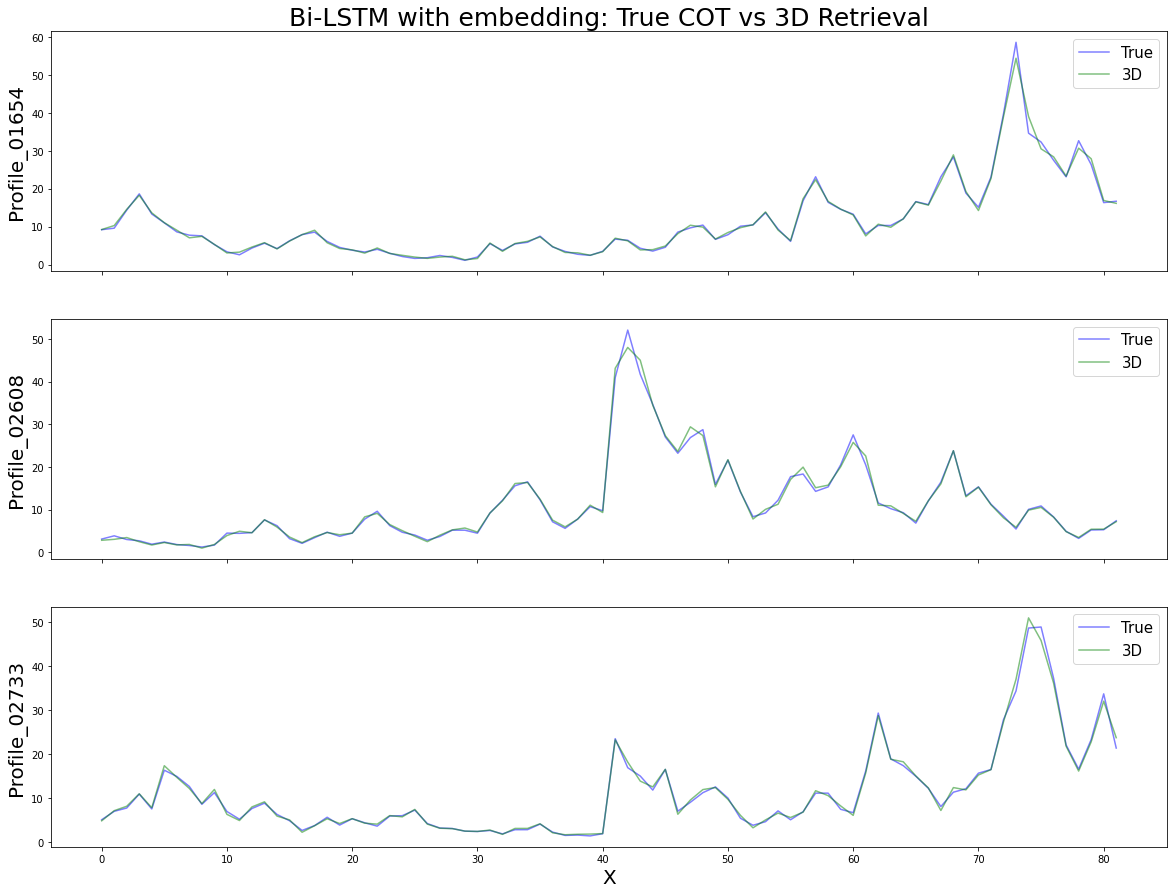

In [17]:
# plotting# ---------------------------------------------------------------------------------------------------
fgnm = "plots/5folds-predict_LSTM with embedding SZA=60 VZA=0 500m-64"+"_"+str(len(history.history['val_loss'])-25)+'_epochs'
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM with embedding: True COT vs 3D Retrieval",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.legend(["True", "3D"],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.legend(["True", "3D"],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.legend(["True", "3D"],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X',fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

In [18]:
physics_retrieval1654=np.load('physics_retrieval1654.npy')
physics_retrieval2608=np.load('physics_retrieval2608.npy')
physics_retrieval2733=np.load('physics_retrieval2733.npy')


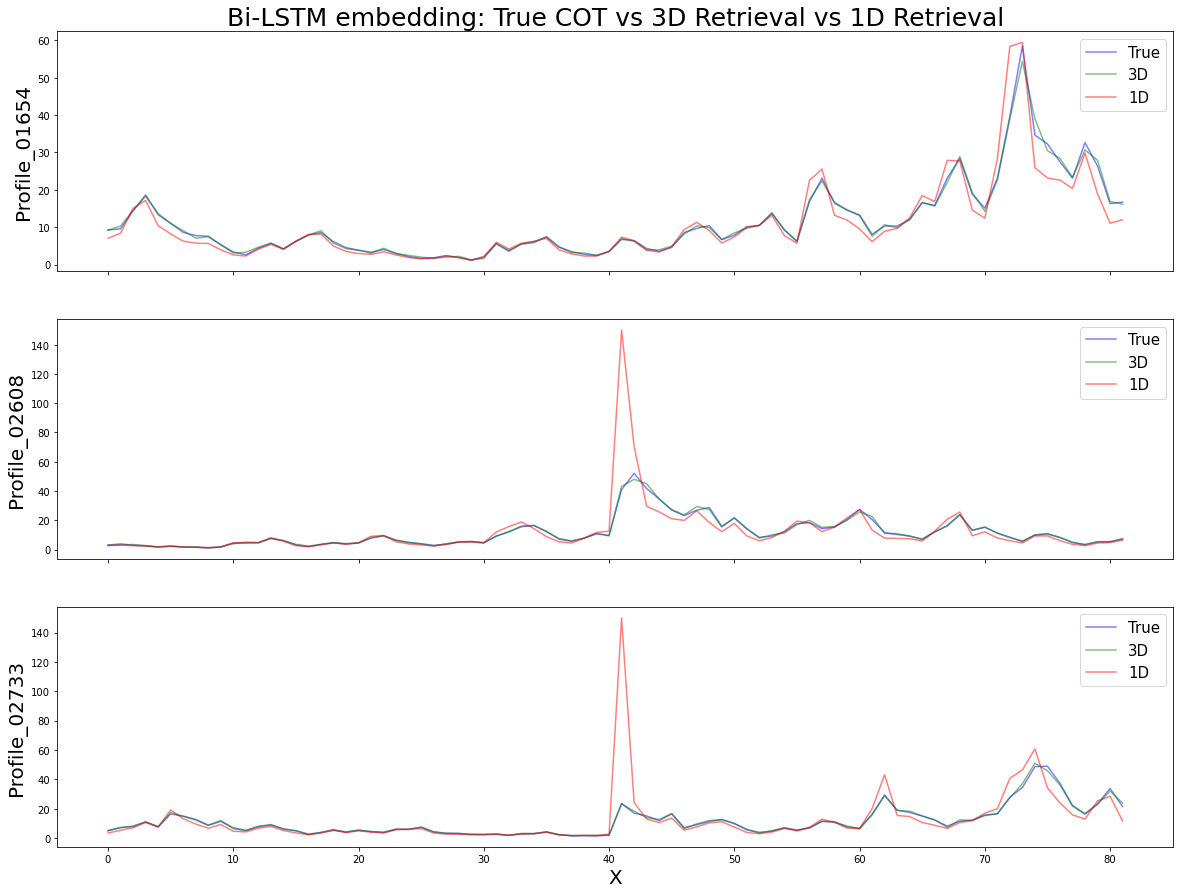

In [19]:
# plotting ---------------------------------------------------------------------------------------------------
fgnm = "plots/3_comparison_Bi-LSTM with embedding SZA=60 VZA=0 500m-64"
fig, axs = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(20,15))

# plots the last three test profiles

#plot the third last profile
ax = axs[0]
ax.set_title(r"Bi-LSTM embedding: True COT vs 3D Retrieval vs 1D Retrieval",fontsize=25)
ax.plot(range(82),test_label[800-3],alpha=0.5,color="blue") #ground truth
ax.plot(range(82),predict1,alpha=0.5,color="green") 
ax.plot(range(82),physics_retrieval1654,alpha=0.5,color="red") 

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_01654",fontsize=20) 

#plot the second last profile
ax = axs[1]
ax.plot(range(82),test_label[800-2],alpha=0.5,color="blue")
ax.plot(range(82),predict2,alpha=0.5,color="green")
ax.plot(range(82),physics_retrieval2608,alpha=0.5,color="red") 

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_02608",fontsize=20)  

# plot the last profile
ax = axs[2]
ax.plot(range(82),test_label[800-1],alpha=0.5,color="blue")
ax.plot(range(82),predict3,alpha=0.5,color="green")
ax.plot(range(82),physics_retrieval2733,alpha=0.5,color="red") 

ax.legend(["True", "3D",'1D'],fontsize=15)
ax.set_ylabel(r"Profile_02733",fontsize=20)  
ax.set_xlabel('X',fontsize=20)

plt.savefig(fgnm+".png",dpi=300,bbox_inches='tight')

# Plotting across predicted 82 COT values¶

In [20]:
std=[]
mean=[]

for k in range(os):
    tmp=[]
    for j in range(800):
        tmp.append(np.abs(predictions[j][k]-test_label[j][k]))
    std.append(np.std(tmp))
    mean.append(np.mean(tmp))

std=np.array(std)
mean=np.array(mean)

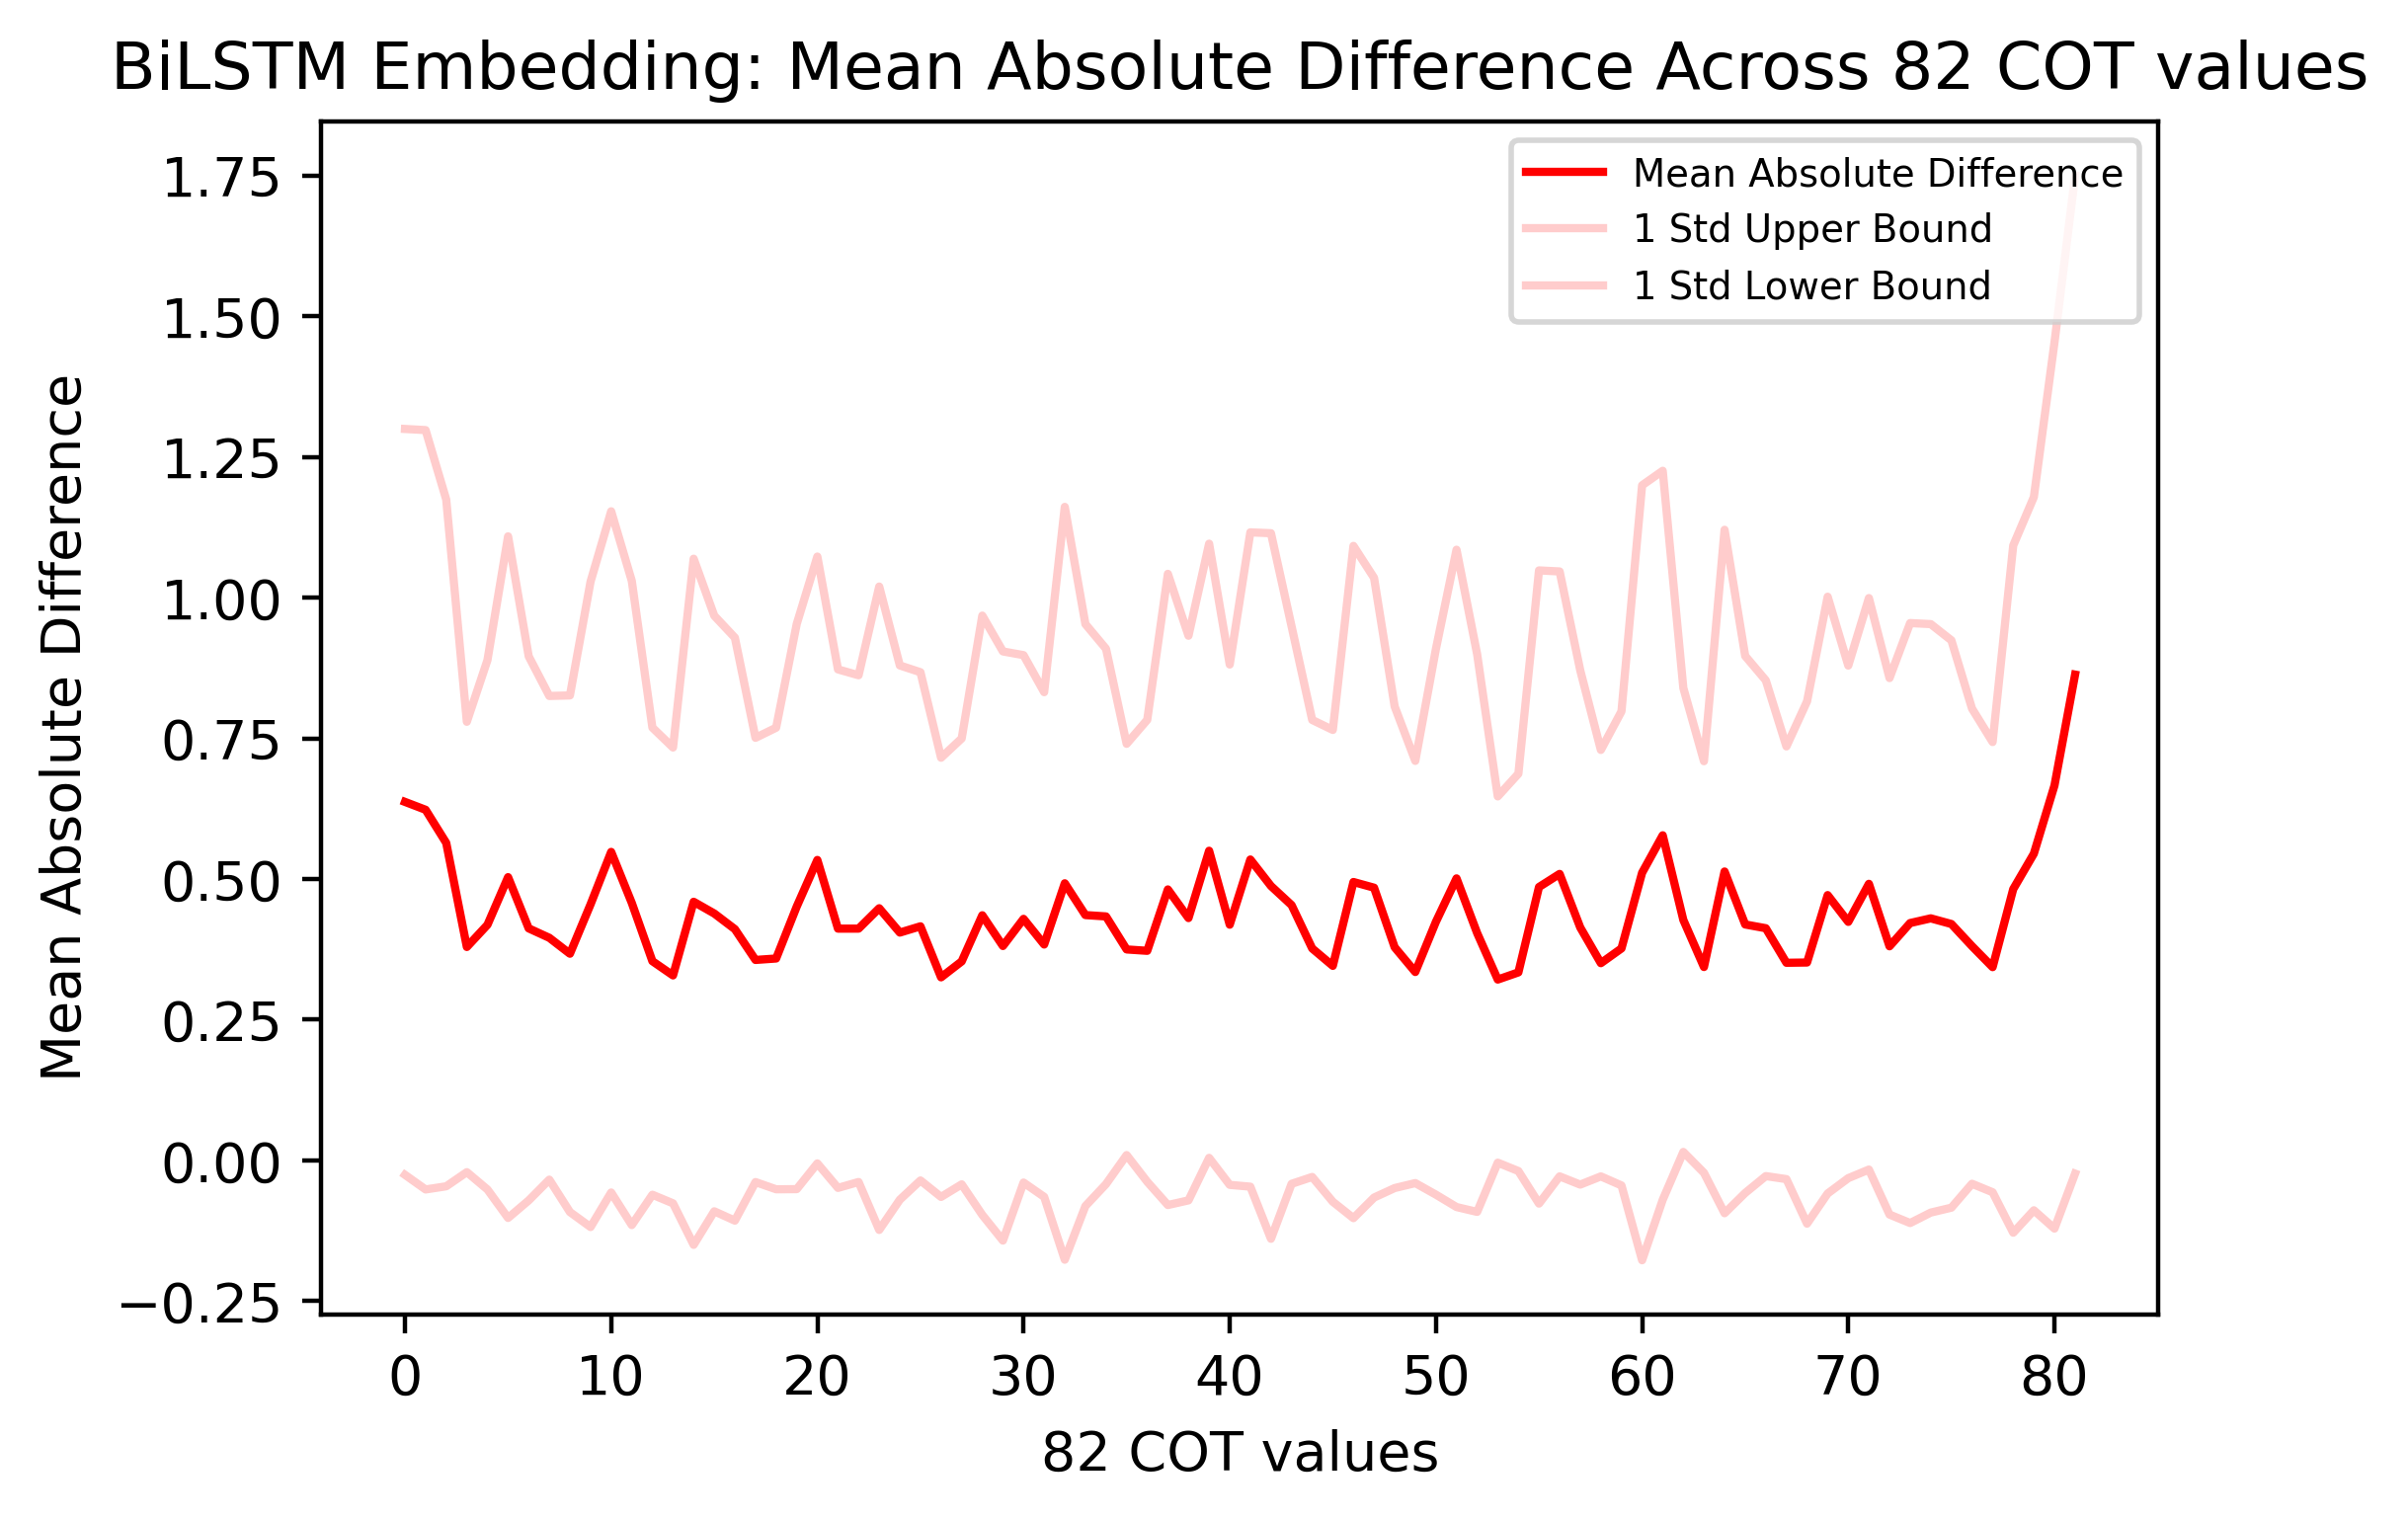

In [22]:
fig, ax = plt.subplots(dpi=400)
ax.plot(mean, '-r', label='Mean Absolute Difference')
ax.plot(mean+std, '-r', label='1 Std Upper Bound',alpha=0.2)
ax.plot(mean-std, '-r', label='1 Std Lower Bound',alpha=0.2)
ax.set_ylabel('Mean Absolute Difference ')  
ax.set_xlabel('82 COT values')

leg = ax.legend(loc=1,fontsize='x-small')
plt.title("BiLSTM Embedding: Mean Absolute Difference Across 82 COT values")

plt.savefig('plots/LSTM_with_Embedding_SZA=60_VZA=0_MeanAbsoluteDifferenceAcross82COTvalues.png',dpi=400)